In [1]:
import pickle
from scipy import integrate
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from astropy import constants as const
import numpy as np
import sys
import multiprocessing

# import classy module
import camb
from camb import model, initialpower

from astropy import cosmology, units, constants

# Definitions

In [2]:
#######################################
########### System settings ###########
#######################################
n_threads = 1
outroot = '/home/gali/Codes/kSZ coding/output/'  # root of all output files
debug = True
late_time = True #if you want to compute the late-time component of the kSZ too


###################
#### Constants ####
###################
s_T = constants.sigma_T.value    # sigma_thomson in SI units [m^2]
c = constants.c.value   # speed of light in SI units [m.s-1]
Mpcm = (1.0 * units.Mpc).to(units.m).value  # one Mpc in [m]
Mpckm = Mpcm / 1e3  # one Mpc in [km]


##########################
#### Cosmo parameters ####
##########################
h = 0.6774000
Om_0 = 0.309
Ol_0 = 0.691
Ob_0 = 0.049
obh2 = Ob_0 * h**2
och2 = (Om_0 - Ob_0) * h**2
A_s = 2.139e-9
n_s = 0.9677
T_cmb = 2.7255
cos=cosmology.FlatLambdaCDM(H0=h*100,Tcmb0=T_cmb,Ob0=Ob_0,Om0=Om_0)
Yp = 0.2453
Xp = 1-Yp
mp = const.m_p.value #kg
mh = constants.m_n.value #kg
rhoc = cos.critical_density0.si.value #kg m-3
nh = Xp*Ob_0*rhoc/mh  # m-3
xe_recomb = 1.7e-4

T_CMB=2.7260 #K
T_CMB_uK=T_CMB*1e6

### linear ell range for kSZ C_ells
ell_min_kSZ = 1.
ell_max_kSZ = 1e5
n_ells_kSZ = 200


########################################
#### Integration/precision settings ####
########################################
### Settings for theta integration
num_th = 50
th_integ = np.linspace(0.000001,np.pi*0.999999,num_th)
mu = np.cos(th_integ)#cos(k.k')
### Settings for k' (=kp) integration
# k' array in [Mpc-1] - over which you integrate
min_logkp = -5.
max_logkp = 1.5
dlogkp = 0.05
kp_integ = np.logspace(
    min_logkp,
    max_logkp,
    int((max_logkp - min_logkp) / dlogkp) + 1
)
### Settings for z integration
z_min = 0.1#0.0015
z_piv = 1.
z_max = 10.
dlogz = 0.05
dz = 0.05

### Setting for P(k) computation
kmin_pk = 10**min_logkp
kmax_pk = 10**max_logkp
nk_pk = 10001
### ell range for TT, EE, TE C_ells
ell_max_CMB = 10000



N_He = 0.0
x = (1 - Yp*(1 - N_He/4))/(1- Yp/2)
mu_e = 1.14
ne = rhoc * Ob_0 * x / (mu_e * mp) # electron mean denstiy in [m-3] (need to multiply by (1+z)^3)


# Functions

In [7]:
from scipy.integrate import simps, cumtrapz, quad, trapz
from scipy import interpolate
from astropy import cosmology
cos=cosmology.FlatLambdaCDM(H0=h*100,Tcmb0=T_cmb,Ob0=Ob_0,Om0=Om_0)


def tau_calc(z): 
    """
    computes tau(z) integrated from xe(z) 
    Params:
        z : list in descending order (from 30 to 0 for instance)
    """
    z = np.sort(z)
    #xe = np.sort(xe)[::-1]
    #csurH = c*100/cos.H(0).si.value  #cm
    #Hdezsurc = cos.H(z).si.value/(c*100) #cm-1

    integ2 = c * s_T * ne / cos.H(z).si.value * (1+z)**2 
    #taudez2 = cumtrapz(integ2[::-1], z, initial=0)[::-1]
    taudez2 = cumtrapz(integ2, z, initial=0)

    return taudez2



########################
#### C_ell function ####
########################
def C_ell_kSZ(ell,late=late_time,debug=debug):
    ### Preliminaries
    # in [Mpc-1]
    k_z_integ = ell / chi_z_integ

    # in [Mpc-1]
    k_min_kp = np.sqrt(k_z_integ[:, None, None]**2 + kp_integ[:, None]**2. - 2. * k_z_integ[:, None, None] * kp_integ[:, None] * mu)

    ### Compute I_tot, in [Mpc^2]
    I = (
        k_z_integ[:, None, None] * (k_z_integ[:, None, None] - 2. * kp_integ[:, None] * mu) * (1 - mu**2) /
        kp_integ[:, None]**2 / (k_z_integ[:, None, None]**2 + kp_integ[:, None]**2 - 2. * k_z_integ[:, None, None] * kp_integ[:, None] * mu)
    )
    
    ### Compute Delta_B^2 integrand, in [s-2.Mpc^2]
    Delta_B2_integrand = (
        k_z_integ[:, None, None]**3. / 2. / np.pi**2. *
        (f_z_integ[:, None, None] * adot_z_integ[:, None, None])**2. *
        #kp_integ[:, None]**2. *  np.sin(th_integ) / (2. * np.pi)**2. * ### why log(10)???
        kp_integ[:, None]**3. * np.log(10.) * np.sin(th_integ) / (2. * np.pi)**2. *
        Pk(k_min_kp,z_integ[:, None, None]) * Pk_lin_integ * I
    )
    ### Compute Delta_B^2, in [s-2.Mpc^2]
    Delta_B2 = simps(simps(Delta_B2_integrand, th_integ), np.log10(kp_integ))

    ### Compute C_kSZ(ell) integrand, unit 1
    C_ell_kSZ_integrand = (
        8. * np.pi**2. / (2. * ell + 1.)**3. * (s_T / c * ne)**2. *
        (1. + z_integ)**4. * Delta_B2 *
        np.exp(-2. * tau_z_integ) * chi_z_integ * dchidz_z_integ * Mpcm**3. ### why Mpcm**3 ???
    )

    ### Compute C_kSZ(ell), no units
    result = trapz(C_ell_kSZ_integrand,z_integ)
    res = [result]      

    sys.stdout.write("...C(ell=%i) = " %ell)
    for r in res:
        sys.stdout.write(' %.2e' %r)
    print(' ')

    del(Delta_B2_integrand)
    del(I)

    return res

# Calculate and plot CMB power spectra using CAMB

In [8]:

pars = camb.CAMBparams()
pars.set_cosmology(H0=h*100,ombh2 = obh2,omch2 = och2,TCMB=T_cmb,tau=0.054)
pars.InitPower.set_params(ns=n_s,r=0,As=A_s)
pars.WantTransfer = True
pars.Reion.set_tau(0.054)
pars.set_for_lmax(ell_max_CMB, lens_potential_accuracy=0);
pars.set_dark_energy()
data= camb.get_background(pars)
results = camb.get_results(pars)

##############################################
#### Cosmo functions & derived parameters ####
##############################################

print("Extract info from CAMB run...")
print('Computing TT TE EE Cl')
results.calc_power_spectra(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
ls = np.arange(totCL.shape[0])

Extract info from CAMB run...
Computing TT TE EE Cl


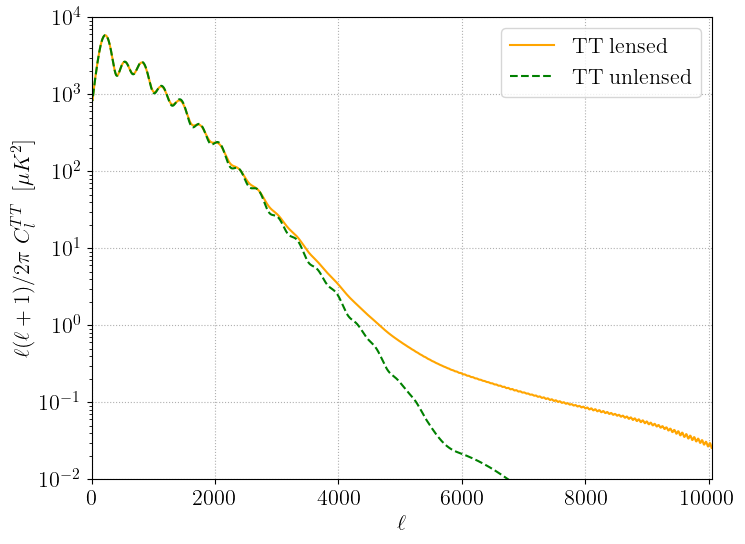

In [9]:
font = {'size': 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
#matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]
# text style
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#plt.figure(dpi=150)
plt.xlim([ls[0],ls[-1]])
#plt.xlim([0,10000])
plt.ylim([1.e-2,1.e4])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1)/ 2 \pi \ C_l^{TT} \,\,\, [\mu K^2]$")
plt.yscale('log')
plt.grid(ls=':')
    
plt.plot(ls,totCL[:,0],color='orange',label=r'$\mathrm{TT\;lensed}$')
plt.plot(ls,unlensedCL[:,0],'g--',label=r'$\mathrm{TT\;unlensed}$')

plt.legend()
plt.show()

# Main code

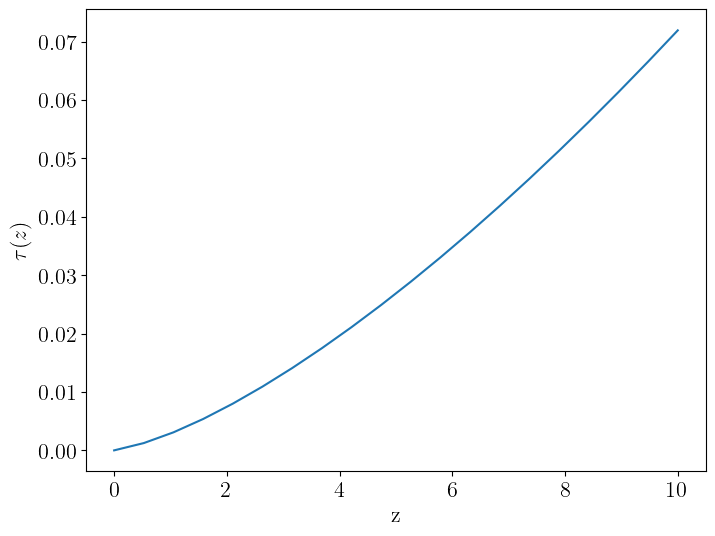

In [10]:
z3=np.linspace(0,z_max,20) 

### Calculating Thomson optical depth and plotting (to check correctness)
tauu = tau_calc(z3)
tauf = interpolate.interp1d(z3,tau_calc(z3)) #interpolation
ynew = tauf(z3)
plt.xlabel('z')
plt.ylabel(r'$\tau(z)$')
plt.plot(z3,tauu)

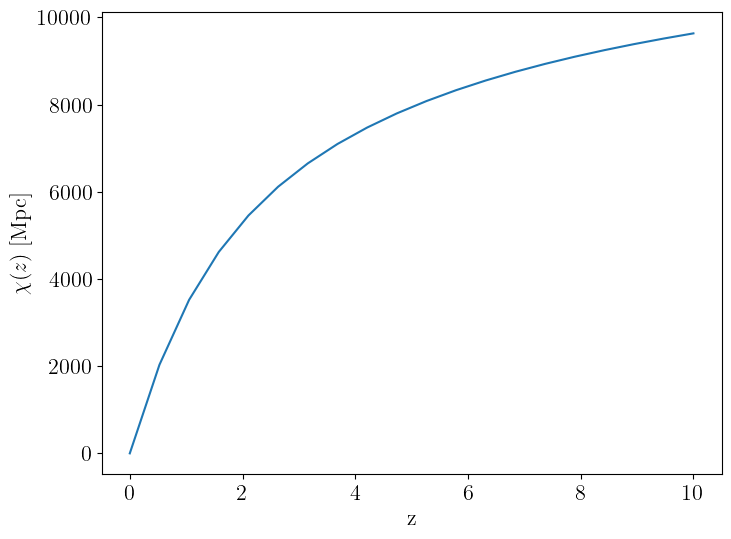

In [11]:
### Hubble function (=adot/a) in SI units [s-1] (CAMB gives km/s/Mpc)
H = np.vectorize(lambda z: results.hubble_parameter(z)/Mpckm)
### Growth rate f (at k=0.1)
f = np.vectorize(lambda z: data.get_redshift_evolution(0.1,z,['growth']).flatten())
### Comoving distance / conformal time in Mpc
D_C = np.vectorize(lambda z: results.comoving_radial_distance(z))

#### Plot the comoving distance (to check)
plt.xlabel('z')
plt.ylabel(r'$\chi(z)$ [Mpc]')
plt.plot(z3, results.comoving_radial_distance(z3))

Text(0, 0.5, '$P(k)$')

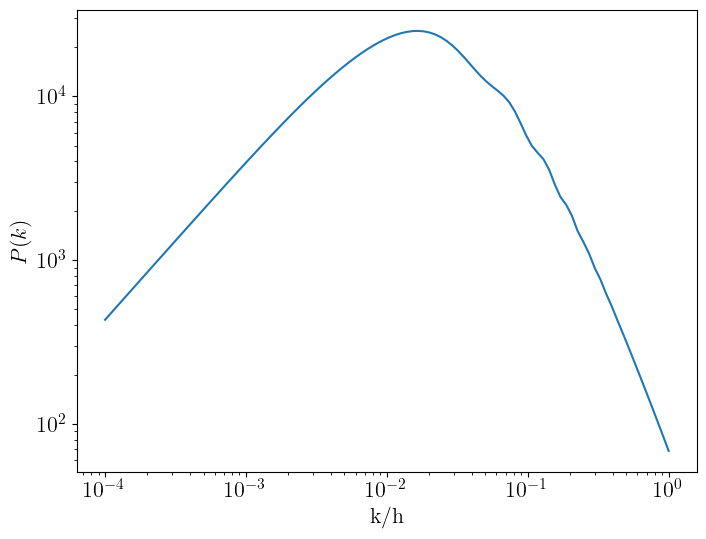

In [12]:
# Calculate and plot the matter power spectrum (just checking)
ppkk = data.get_matter_power_spectrum(minkh=0.0001, maxkh=1.0, npoints=100, var1=None, var2=None, have_power_spectra=False, params=pars)
plt.loglog(ppkk[0], ppkk[2][0])
plt.xlabel('k/h')
plt.ylabel(r'$P(k)$')


In [13]:
## Linear matter power spectrum P(z,k) - no hubble units, result in (Mpc)^3
kmax_pk = ell_max_kSZ/D_C(z_min)
assert (kmax_pk < 2e3),'Error, k too large for P(k) extrapolation, need to modify either ell_max or z_min'
print('Interpolating linear power spectrum')
interp_l=camb.get_matter_power_interpolator(pars,nonlinear=False,kmax=kmax_pk,hubble_units=False,k_hunit=False,zmax=z_max, var1=model.Transfer_nonu,var2=model.Transfer_nonu)
Pk_lin=np.vectorize(lambda k,z : interp_l.P(z,k))
### Non-linear matter power spectrum
print('Interpolating non linear power spectrum')
interp_nl=camb.get_matter_power_interpolator(pars,nonlinear=True,kmax=kmax_pk,hubble_units=False,k_hunit=False,zmax=z_max, var1=model.Transfer_nonu,var2=model.Transfer_nonu)
Pk = np.vectorize(lambda k, z : interp_nl.P(z,k))
## Hydrogen number density function in SI units [m-3]
#n_H = lambda z: nh*(1.+z)**3.
print('Finished computing cosmo functions')

Interpolating linear power spectrum
Interpolating non linear power spectrum
Finished computing cosmo functions


In [14]:
z_integ = np.arange(z_min, z_max, step=dz)

### This kind of sensitivity in the lower z range is required for astropysical purposes.
# z_integ = np.concatenate(
#         (
#             np.logspace(np.log10(z_min),np.log10(z_piv),int((np.log10(z_piv) - np.log10(z_min)) / dlogz) + 1),
#             np.arange(z_piv,z_max,step=dz))
#         )


chi_z_integ = D_C(z_integ)  # comoving distance to z in [Mpc]
dchidz_z_integ = c / H(z_integ)  # Hubble parameter in SI units [m]
f_z_integ = f(z_integ)  # growth rate, no units
adot_z_integ = (1. / (1. + z_integ)) * H(z_integ)  # in SI units [s-1]
# n_H_z_integ = n_H(z_integ)  # number density of baryons in SI units [m-3]
# x_i_z_integ = xe(z_integ) # reionisation history
tau_z_integ = tauf(z_integ)  # thomson optical depth
Pk_lin_integ = Pk_lin(kp_integ[:, None],z_integ[:, None, None]) #linear matter power spectrum
Pk_integ = Pk(kp_integ[:, None],z_integ[:, None, None]) #linear matter power spectrum

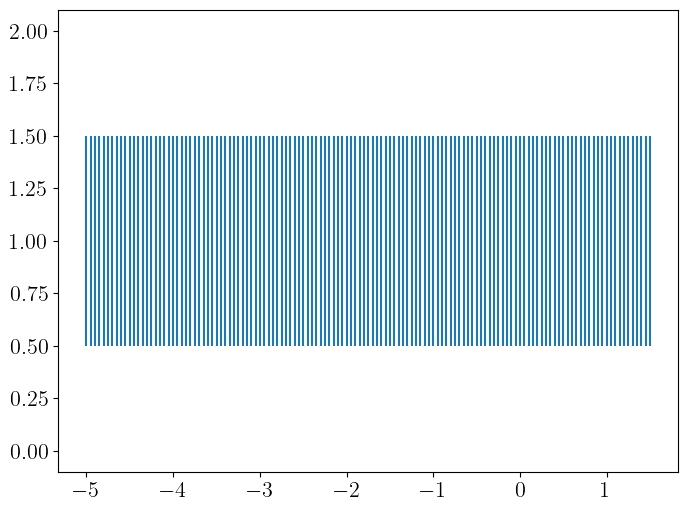

In [15]:
#print(kp_integ)
plt.eventplot(np.log10(kp_integ))

In [16]:
print('\nComputing for %i l on range [%i,%i] with %i threads' %(n_ells_kSZ,ell_min_kSZ,ell_max_kSZ,n_threads))
print("Begin kSZ calculation...")
ells = np.linspace(ell_min_kSZ, ell_max_kSZ, n_ells_kSZ, dtype=int)
C_ells_kSZ = np.array(multiprocessing.Pool(n_threads).map(C_ell_kSZ, ells))


######################
### Write outputs ####
######################
### Writing kSZ C_ells
np.savetxt(outroot+"kSZ_PS_kSZ_Cells.txt",
    np.c_[ells,C_ells_kSZ],
    header="ell   kSZ tot   kSZ patchy    NB: dimensionless C_l's",delimiter=' ',fmt='%.5e')
### Writing TT/TE/EE unlensed C_ells
np.savetxt(outroot+"kSZ_PS_CMB_Cells.txt",
    np.transpose([ls, unlensedCL[:,0],unlensedCL[:,1],unlensedCL[:,3]]),
    header="ell   TT   EE   TE    NB: dimensionless [l(l+1)/2pi] C_l's")
### Writing TT/TE/EE lensed C_ells
np.savetxt(outroot+"kSZ_PS_lensed_CMB_Cells.txt",
    np.transpose([ls, totCL[:,0],totCL[:,1],totCL[:,3]]),
    header="ell   TT   EE   TE    NB: dimensionless [l(l+1)/2pi] C_l's")


Computing for 200 l on range [1,100000] with 1 threads
Begin kSZ calculation...
...C(ell=1) =  5.70e-20 
...C(ell=503) =  3.17e-18 
...C(ell=1006) =  1.48e-18 
...C(ell=1508) =  8.61e-19 
...C(ell=2011) =  5.68e-19 
...C(ell=2513) =  4.07e-19 
...C(ell=3016) =  3.07e-19 
...C(ell=3518) =  2.41e-19 
...C(ell=4021) =  1.95e-19 
...C(ell=4523) =  1.62e-19 
...C(ell=5026) =  1.37e-19 
...C(ell=5528) =  1.17e-19 
...C(ell=6031) =  1.02e-19 
...C(ell=6533) =  8.94e-20 
...C(ell=7036) =  7.92e-20 
...C(ell=7538) =  7.07e-20 
...C(ell=8041) =  6.36e-20 
...C(ell=8543) =  5.75e-20 
...C(ell=9046) =  5.23e-20 
...C(ell=9548) =  4.78e-20 
...C(ell=10051) =  4.38e-20 
...C(ell=10553) =  4.04e-20 
...C(ell=11056) =  3.73e-20 
...C(ell=11558) =  3.46e-20 
...C(ell=12061) =  3.22e-20 
...C(ell=12563) =  3.01e-20 
...C(ell=13066) =  2.81e-20 
...C(ell=13568) =  2.63e-20 
...C(ell=14071) =  2.47e-20 
...C(ell=14573) =  2.33e-20 
...C(ell=15076) =  2.20e-20 
...C(ell=15578) =  2.08e-20 
...C(ell=16081)

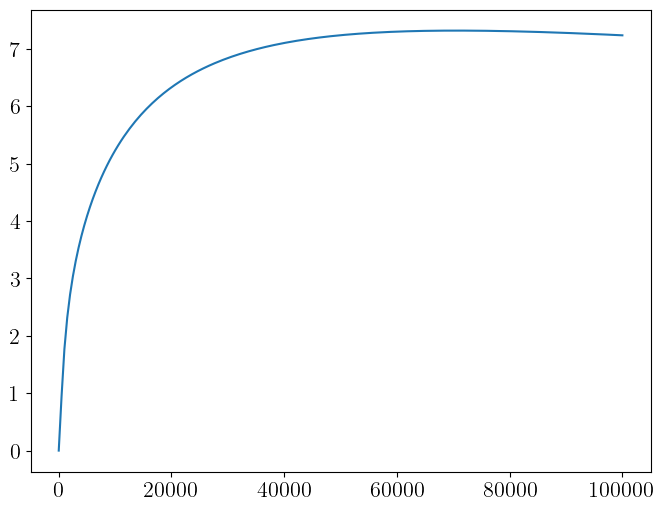

In [17]:
plt.plot(ells, ells * (ells+1) / (2*np.pi) * C_ells_kSZ.flatten() * T_CMB_uK**2)
#plt.xlim(0,1e4)
#plt.ylim(0,6)

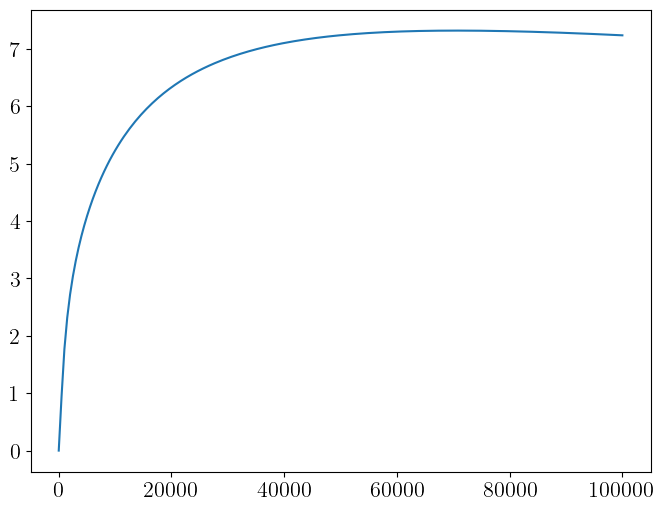

In [22]:
kSZ = np.loadtxt(outroot+"kSZ_PS_kSZ_Cells.txt")
ll = kSZ[:,0]
Cll = kSZ[:,1]

outroot = '/home/gali/Codes/kSZ coding/output/'
plt.plot(ll, ll * (ll+1) / (2*np.pi) * Cll * T_CMB_uK**2)


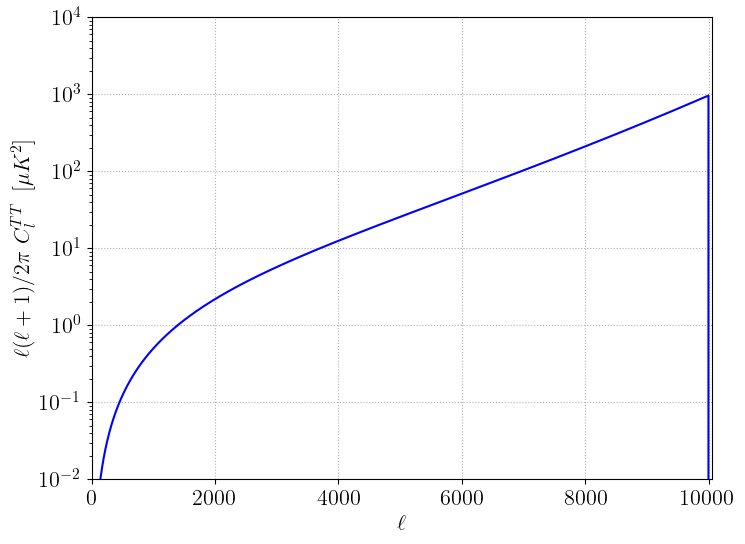

In [20]:
### Calculate instrumental noise for CMB-S4

# sky cover
f_sky = 0.4
N_freq = 2

arcmin_to_rad = 1/60*np.pi/180

### First entry is for SO, second for CMB-S4
theta_FWHM = np.array([1.4, 1.4]) 
s = np.array([6.,  1.])*arcmin_to_rad #in micro-Kelvin

sigma_b = theta_FWHM*arcmin_to_rad/np.sqrt(8*np.log(2))
N_exp = len(s)

noise_S4_TT = np.zeros([N_freq,len(ls)])
for j in range(N_freq):
    for l in range(2,ell_max_CMB+1):
        noise_S4_TT[j, l-2] = l*(l+1)/2/np.pi*(s[j])**2*np.exp(l*(l+1)*(sigma_b[j])**2)


#plt.figure(dpi=150)
plt.xlim([ls[0],ls[-1]])
#plt.xlim([0,10000])
plt.ylim([1.e-2,1.e4])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1)/ 2 \pi \ C_l^{TT} \,\,\, [\mu K^2]$")
plt.yscale('log')
plt.grid(ls=':')
plt.plot(ls, noise_S4_TT[0], color='blue',label='total CMB')

In [ ]:
n=int(n_ells_kSZ/10)
ll = ells[n:]

In [41]:
ells[2:]

array([  1006,   1508,   2011,   2513,   3016,   3518,   4021,   4523,
         5026,   5528,   6031,   6533,   7036,   7538,   8041,   8543,
         9046,   9548,  10051,  10553,  11056,  11558,  12061,  12563,
        13066,  13568,  14071,  14573,  15076,  15578,  16081,  16583,
        17086,  17588,  18091,  18593,  19096,  19598,  20101,  20603,
        21106,  21608,  22111,  22613,  23116,  23618,  24121,  24623,
        25126,  25628,  26131,  26633,  27136,  27638,  28141,  28643,
        29146,  29648,  30151,  30653,  31156,  31658,  32161,  32663,
        33166,  33669,  34171,  34674,  35176,  35679,  36181,  36684,
        37186,  37689,  38191,  38694,  39196,  39699,  40201,  40704,
        41206,  41709,  42211,  42714,  43216,  43719,  44221,  44724,
        45226,  45729,  46231,  46734,  47236,  47739,  48241,  48744,
        49246,  49749,  50251,  50754,  51256,  51759,  52261,  52764,
        53266,  53769,  54271,  54774,  55276,  55779,  56281,  56784,
      

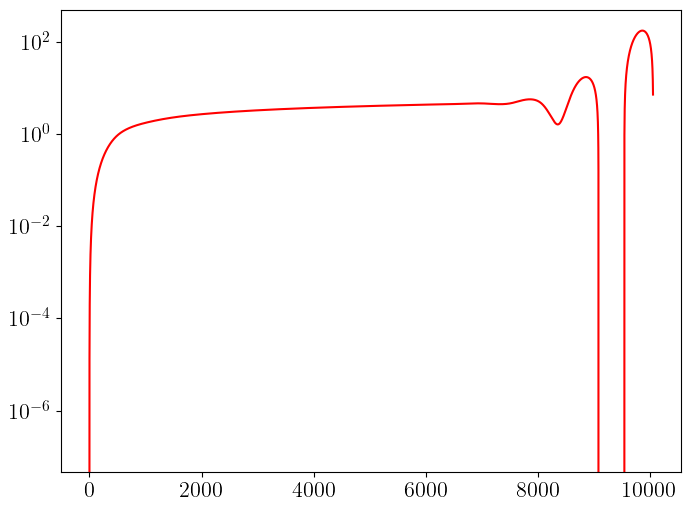

In [47]:
plt.semilogy(ls, kSZ_new, color='red',label='late-time kSZ')
#plt.xlim([ls[0],ls[-1]])
#plt.xlim([0,10000])

In [ ]:
n=2#int(n_ells_kSZ/10)
ll = ells[n:]
Cll_kSZ = ells * (ells+1) / (2*np.pi) *C_ells_kSZ.flatten() * T_CMB_uK**2
Cll_kSZ_cut = ll * (ll+1) / (2*np.pi) *C_ells_kSZ.flatten()[n:] * T_CMB_uK**2

# Interpolating kSZ power spectrum to add with the CMB one
nells = np.insert(ells,0,0)
nells = np.insert(nells,len(nells),10050)
nCll_kSZ = np.insert(Cll_kSZ,0,0)
nCll_kSZ = np.insert(nCll_kSZ,len(nCll_kSZ),nCll_kSZ[len(Cll_kSZ)])
kszf = interpolate.interp1d(nells,nCll_kSZ, kind='cubic') #interpolation
kSZ_new = kszf(ls)


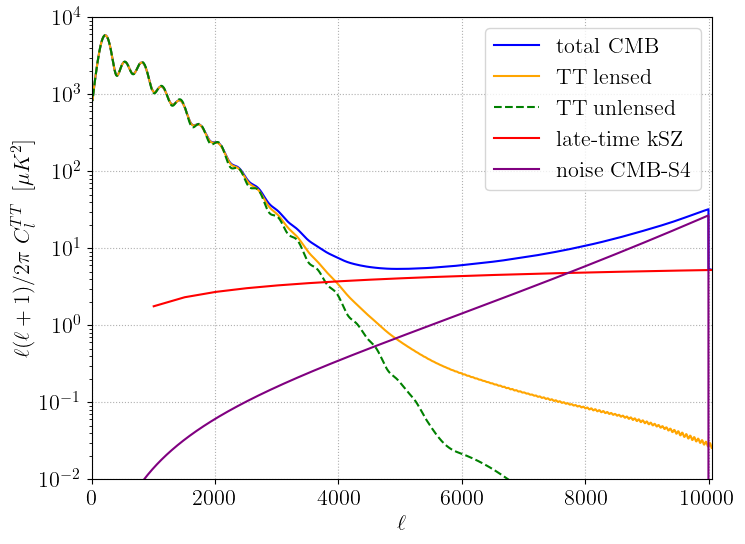

In [56]:
font = {'size': 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
#matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]
# text style
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#plt.figure(dpi=150)
plt.xlim([ls[0],ls[-1]])
#plt.xlim([0,10000])
plt.ylim([1e-2,1e4])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1)/ 2 \pi \ C_l^{TT} \,\,\, [\mu K^2]$")
plt.yscale('log')
plt.grid(ls=':')
    


n=2#int(n_ells_kSZ/10)
ll = ells[n:]
Cll_kSZ = ells * (ells+1) / (2*np.pi) *C_ells_kSZ.flatten() * T_CMB_uK**2
Cll_kSZ_cut = ll * (ll+1) / (2*np.pi) *C_ells_kSZ.flatten()[n:] * T_CMB_uK**2

# Interpolating kSZ power spectrum to add with the CMB one
nells = np.insert(ells,0,0)
nells = np.insert(nells,len(nells),11000)
nCll_kSZ = np.insert(Cll_kSZ,0,0)
nCll_kSZ = np.insert(nCll_kSZ,len(nCll_kSZ),nCll_kSZ[len(Cll_kSZ)])
kszf = interpolate.interp1d(nells,nCll_kSZ, kind='cubic') #interpolation
kSZ_new = kszf(ls)

plt.plot(ls, kSZ_new + totCL[:,0] + noise_S4_TT[1], color='blue',label='total CMB')
plt.plot(ls,totCL[:,0],color='orange',label=r'$\mathrm{TT\;lensed}$')
plt.plot(ls,unlensedCL[:,0],'g--',label=r'$\mathrm{TT\;unlensed}$')
plt.plot(ll, Cll_kSZ_cut, color='red',label='late-time kSZ')
plt.plot(ls, noise_S4_TT[1], color='purple',label='noise CMB-S4')


plt.legend()
plt.show()

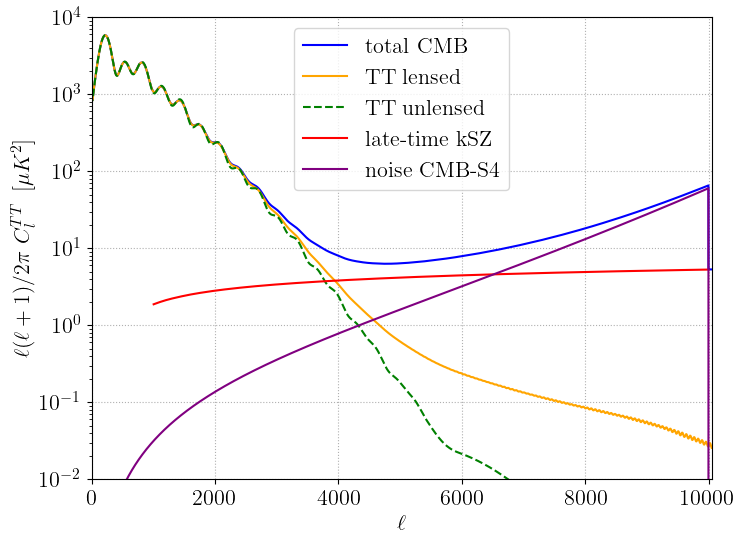

In [220]:
font = {'size': 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
#matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]
# text style
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#plt.figure(dpi=150)
plt.xlim([ls[0],ls[-1]])
#plt.xlim([0,10000])
plt.ylim([1.e-2,1.e4])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1)/ 2 \pi \ C_l^{TT} \,\,\, [\mu K^2]$")
plt.yscale('log')
plt.grid(ls=':')
    


n=int(n_ells_kSZ/10)
ll = ells[n:]
Cll_kSZ = ells * (ells+1) / (2*np.pi) *C_ells_kSZ.flatten() * T_CMB_uK**2
Cll_kSZ_cut = ll * (ll+1) / (2*np.pi) *C_ells_kSZ.flatten()[n:] * T_CMB_uK**2

# Interpolating kSZ power spectrum to add with the CMB one
nells = np.insert(ells,0,0)
nells = np.insert(nells,len(nells),10050)
nCll_kSZ = np.insert(Cll_kSZ,0,0)
nCll_kSZ = np.insert(nCll_kSZ,len(nCll_kSZ),nCll_kSZ[len(Cll_kSZ)])
kszf = interpolate.interp1d(nells,nCll_kSZ, kind='cubic') #interpolation
kSZ_new = kszf(ls)

plt.plot(ls, kSZ_new + totCL[:,0] + noise_S4_TT[1], color='blue',label='total CMB')
plt.plot(ls,totCL[:,0],color='orange',label=r'$\mathrm{TT\;lensed}$')
plt.plot(ls,unlensedCL[:,0],'g--',label=r'$\mathrm{TT\;unlensed}$')
plt.plot(ll, Cll_kSZ_cut, color='red',label='late-time kSZ')
plt.plot(ls, noise_S4_TT[1], color='purple',label='noise CMB-S4')


plt.legend()
plt.show()

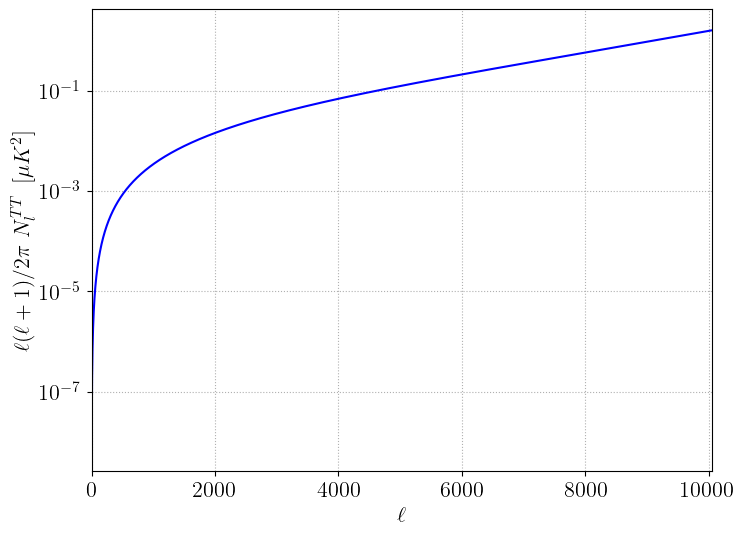

In [262]:
### Parameters taken from 2010.07193 Eq. 21

arcmin_to_rad = 1/60*np.pi/180
#theta_FWHM = 5.
theta_FWHM = 1.
sigma_b = theta_FWHM*arcmin_to_rad/np.sqrt(8*np.log(2.))
#AP = 43*arcmin_to_rad # 1 micro kelvin
AP = 0.5*arcmin_to_rad # [uK]

noise_P_TT = np.array([])
for l in ls:
    noise_P_TT = np.append(noise_P_TT,[l*(l+1)/2/np.pi*AP**2*np.exp(l*(l+1)*sigma_b**2)])

#plt.figure(dpi=150)
plt.xlim([ls[0],ls[-1]])#plt.xlim([0,10000])
#plt.ylim([1.e-2,1.e4])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1)/ 2 \pi \ N_l^{TT} \,\,\, [\mu K^2]$")
#plt.xscale('log')
plt.yscale('log')
plt.grid(ls=':')
plt.plot(ls, noise_P_TT, color='blue',label='Noise CMB')


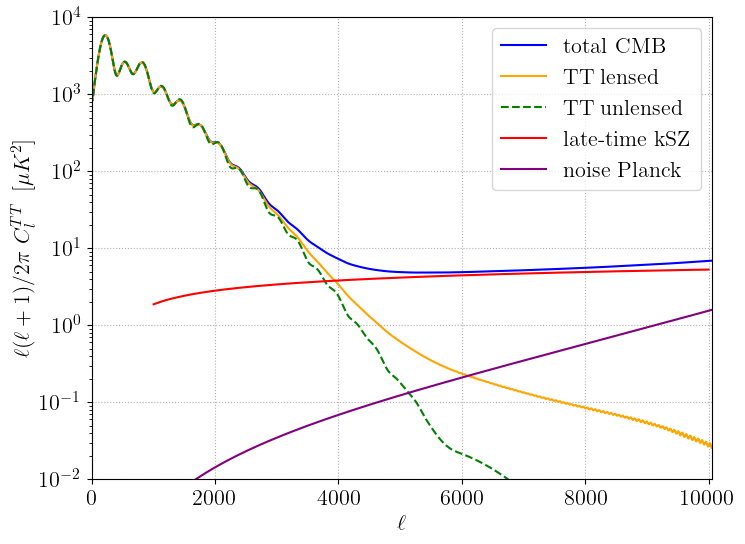

In [263]:
font = {'size': 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
#matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]
# text style
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#plt.figure(dpi=150)
plt.xlim([ls[0],ls[-1]])
#plt.xlim([0,10000])
plt.ylim([1.e-2,1.e4])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1)/ 2 \pi \ C_l^{TT} \,\,\, [\mu K^2]$")
plt.yscale('log')
plt.grid(ls=':')
    


n=int(n_ells_kSZ/10)
ll = ells[n:]
Cll_kSZ = ells * (ells+1) / (2*np.pi) *C_ells_kSZ.flatten() * T_CMB_uK**2
Cll_kSZ_cut = ll * (ll+1) / (2*np.pi) *C_ells_kSZ.flatten()[n:] * T_CMB_uK**2

# Interpolating kSZ power spectrum to add with the CMB one
nells = np.insert(ells,0,0)
nells = np.insert(nells,len(nells),10050)
nCll_kSZ = np.insert(Cll_kSZ,0,0)
nCll_kSZ = np.insert(nCll_kSZ,len(nCll_kSZ),nCll_kSZ[len(Cll_kSZ)])
kszf = interpolate.interp1d(nells,nCll_kSZ, kind='cubic') #interpolation
kSZ_new = kszf(ls)

plt.plot(ls, kSZ_new + totCL[:,0] + noise_P_TT, color='blue',label='total CMB')
plt.plot(ls,totCL[:,0],color='orange',label=r'$\mathrm{TT\;lensed}$')
plt.plot(ls,unlensedCL[:,0],'g--',label=r'$\mathrm{TT\;unlensed}$')
plt.plot(ll, Cll_kSZ_cut, color='red',label='late-time kSZ')
plt.plot(ls, noise_P_TT, color='purple',label='noise Planck')


plt.legend()
plt.show()

In [238]:
print(Mpcm)

3.085677581491367e+22


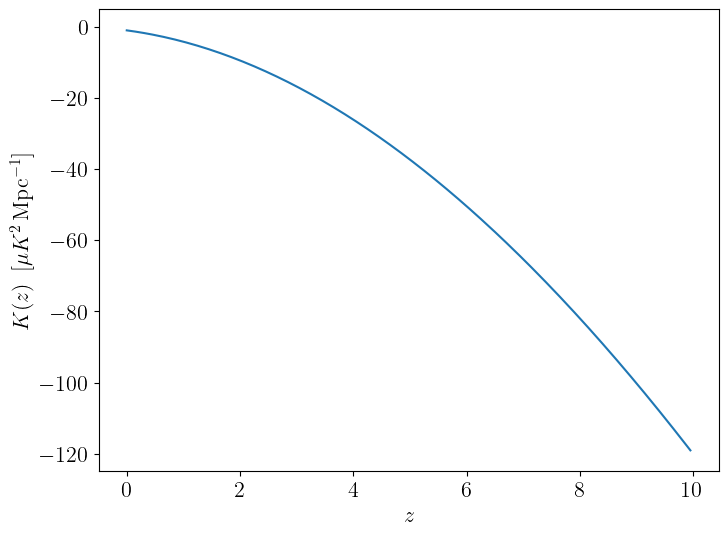

In [242]:
### Calculate the function K(z) - the kSZ radial weight function with units [uK.Mpc-1]
K_z = -1. * T_CMB_uK * s_T * ne * np.exp(-1. * tau_z_integ) * (1 + z_integ)**2 * Mpcm
plt.xlabel(r"$z$")
plt.ylabel(r"$K(z) \,\,\, [\mu K^2 \, \mathrm{Mpc^{-1}}]$")
plt.plot(z_integ, K_z)